Building the Upstream using raw ACE and Wind Data and Comparing it to OMNI and Artemis and seeing if we are better than NASA.

Packages

In [10]:
# region <Importing Packages>
import datetime as dt

import pandas as pd
import pyspedas
#from pyqtgraph.graphicsItems.PlotDataItem import dataType
from pyspedas import tplot
import matplotlib.pyplot as plt
from pytplot import get_data
#import pandas as pd
import numpy as np
# endregion

05-Nov-25 15:58:53: C:\Users\Brian\anaconda3\envs\Research_Espen\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



Importing Data (ACE, Wind, OMNI)

In [11]:
# region <Getting Data>
def get_omni(start, stop):
    return pyspedas.projects.omni.data(trange=[start, stop], datatype='1min', level='hro2', time_clip=True)

def get_ace(start, stop):
    pyspedas.projects.ace.mfi(trange=[start, stop], datatype='h3', time_clip=True)
    pyspedas.projects.ace.swe(trange=[shifted_start, stop],datatype='h0', time_clip=True)

def get_wind(start, stop):
    return pyspedas.projects.wind.mfi(trange=[start, stop], datatype='h0', time_clip=True)

def get_art(start, stop):
    return pyspedas.projects.themis.fgm(trange=[start,stop],probe=['b','c'],level="l2",time_clip=True)
# endregion

In [33]:

#This is where you input where to start and stop
start = "2016-05-06/12:00:00"
stop = "2016-05-07/11:59:59"

#This code allows us to shift the start a couple of hours back.
sec = 5400
date_start = pd.to_datetime(start)
shift = pd.Timedelta(sec, unit='s')
ts = date_start-shift
shifted_start = ts.strftime('%Y-%m-%d %H:%M:%S')


In [65]:
pyspedas.projects.ace.swe(trange=[shifted_start, stop],datatype='h0', time_clip=True)


05-Nov-25 17:17:04: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2016/
05-Nov-25 17:17:15: Remote index took 11.0 seconds to return, may indicate problems on remote server (index_slow)
05-Nov-25 17:17:16: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160506_v11.cdf to ace_data/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160506_v11.cdf
05-Nov-25 17:17:16: Download of ace_data/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160506_v11.cdf complete, 0.123 MB in 0.2 sec (0.644 MB/sec) (transfer_normal)
05-Nov-25 17:17:28: Downloading https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160507_v11.cdf to ace_data/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160507_v11.cdf
05-Nov-25 17:17:28: Download of ace_data/swepam/level_2_cdaweb/swe_h0/2016/ac_h0_swe_20160507_v11.cdf complete, 0.125 MB in 10.9 sec (0.011 MB/sec) (transfer_slow)


['Np',
 'Vp',
 'Tpr',
 'alpha_ratio',
 'V_GSE',
 'V_RTN',
 'V_GSM',
 'SC_pos_GSE',
 'SC_pos_GSM']

In [43]:
# region <Importing OMNI Data>
#This code allows us to get data from OMNI.

get_omni(start, stop)
omni = pd.DataFrame({
    'Time': get_data('BZ_GSM')[0],
    'BY': get_data('BY_GSM')[1],
    'BZ': get_data('BZ_GSM')[1],
    'IMF': get_data('IMF')[1],
    "ts": get_data('Timeshift')[1],
    'VX': get_data('Vx')[1],
    'VY': get_data('Vy')[1],
    'VZ': get_data('Vz')[1],
    'Density': get_data('proton_density')[1],
    'Temp': get_data('T')[1],
    'X': get_data('x')[1],
})

#The data will then be interpolated to 1 minute intervals
omni['Time'] = pd.to_datetime(omni['Time'], unit='s')
omni = omni.set_index('Time')
omni = omni.resample('min').mean().interpolate(method='linear').ffill().bfill()
omni = omni.reset_index()
# endregion

In [82]:
# region <Importing ACE Data>
#This code allows us to get data from ACE.

get_ace(shifted_start, stop)
ace = pd.DataFrame({
    'Time': get_data('BGSM')[0],
    'BX': get_data('BGSM')[1][:,0],
    'BY': get_data('BGSM')[1][:,1],
    'BZ': get_data('BGSM')[1][:,2],
    'VX': get_data('V_GSM')[1][:,0],
    'VY': get_data('V_GSM')[1][:,1],
    'VZ': get_data('V_GSM')[1][:,2],
    "Np": get_data('Np')[1],
    "Temp": get_data('Tpr')[1],

},columns = ['Time', 'BZ']).replace(to_replace=[-1.0e31], value=np.nan)


#The data will then be interpolated to 1 second intervals
ace['Time'] = pd.to_datetime(ace['Time'], unit='s')
ace = ace.set_index('Time')
ace = ace.resample('s').mean().interpolate(method='linear').ffill()
ace = ace.reset_index()
# endregion

05-Nov-25 17:26:17: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/mag/level_2_cdaweb/mfi_h3/2016/
05-Nov-25 17:26:28: Remote index took 10.9 seconds to return, may indicate problems on remote server (index_slow)
05-Nov-25 17:26:29: File is current: ace_data/mag/level_2_cdaweb/mfi_h3/2016/ac_h3_mfi_20160506_v02.cdf
05-Nov-25 17:26:41: File is current: ace_data/mag/level_2_cdaweb/mfi_h3/2016/ac_h3_mfi_20160507_v02.cdf


In [16]:
# region <Importing WIND Data>
#This code allows us to get data from Wind.
get_wind(shifted_start, stop)
wind = pd.DataFrame({
    'Time': get_data('B3GSM')[0],
    'BZ': get_data('B3GSM')[1][:,2]
}, columns = ['Time', 'BZ']).replace(to_replace=[-1.0e31], value=np.nan)


#The data will then be interpolated to 1 second intervals
wind['Time'] = pd.to_datetime(wind['Time'], unit='s')
wind = wind.set_index('Time')
wind = wind.resample('s').mean().interpolate(method='linear').ffill()
wind = wind.reset_index()
# endregion

05-Nov-25 16:00:01: File is current: wind_data/wind_masters/wi_h0_mfi_00000000_v01.cdf
05-Nov-25 16:00:02: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2016/
05-Nov-25 16:00:12: Remote index took 10.9 seconds to return, may indicate problems on remote server (index_slow)
05-Nov-25 16:00:13: File is current: wind_data/mfi/mfi_h0/2016/wi_h0_mfi_20160506_v05.cdf
05-Nov-25 16:00:25: File is current: wind_data/mfi/mfi_h0/2016/wi_h0_mfi_20160507_v05.cdf


Getting Upstream data

In [93]:
upstream = []
upstream_time = []
shift = []
pt_ID = []
for i in range(len(omni['IMF'])):
    delta = pd.Timedelta(omni['ts'][i], unit='s')
    time = omni['Time'][i] - delta
    shift.append(delta)


    match omni['IMF'][i]:

        #If the spacecraft ID is 71, get the data from ace.
        case 71:
            ind = ace.loc[ace['Time'] == omni['Time'].iloc[i]-delta].index[0]
            #if ace doesn't have the data, get the data from wind
            if np.isnan(ace['BZ'][ind]):
                print("found a nan")
                ind = wind.loc[wind['Time'] == omni['Time'].iloc[i]-delta].index[0]
                upstream.append(wind['BZ'][ind])
                upstream_time.append(time)
                pt_ID.append(51)
            else:
                upstream.append(ace['BZ'][ind])
                upstream_time.append(time)
                pt_ID.append(71)


        #if the spacecraft ID is 51 or 52 get the data from wind
        case 51 | 52:
            ind = wind.loc[wind['Time'] == omni['Time'].iloc[i]-delta].index[0]
            #if wind doesn't have the data, get the data from ace
            if np.isnan(wind['BZ'][ind]):
                print("found a nan")
                ind = ace.loc[ace['Time'] == omni['Time'].iloc[i]-delta].index[0]
                upstream.append(ace['BZ'][ind])
                upstream_time.append(time)
                pt_ID.append(71)
            else:
                upstream.append(wind['BZ'][ind])
                upstream_time.append(time)
                pt_ID.append(51)


        case _:
            id = pt_ID[-1]
            upstream.append(np.nan)
            upstream_time.append(time)
            pt_ID.append(id)
upstream_wind = pd.DataFrame({'Time': upstream_time, 'BZ': upstream, 'ID': pt_ID})
upstream_wind = upstream_wind.sort_values(by='Time')
upstream_wind = upstream_wind.set_index('Time')
#upstream_wind = upstream_wind.resample('min').mean().ffill().interpolate(method='linear').bfill()
upstream_wind = upstream_wind.reset_index()

#avg_ts = pd.to_timedelta(pd.Series(shift)).mean()
#print(avg_ts)


Plotting Data

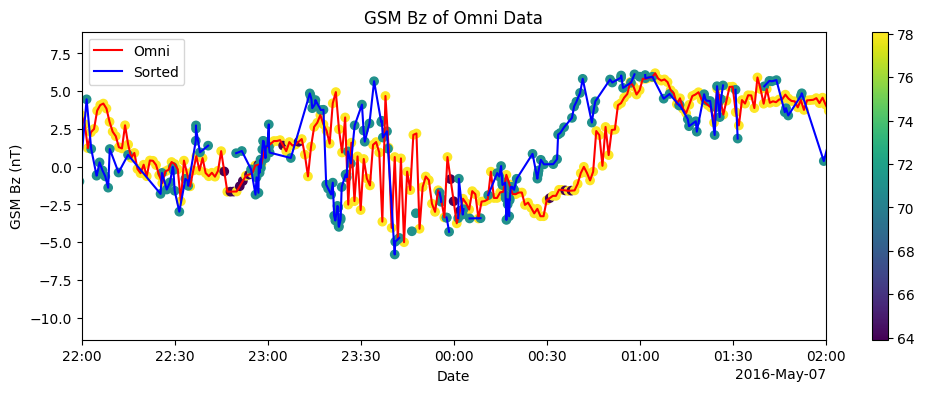

In [92]:
fig, ax = plt.subplots(figsize = (12,4))
#plt.plot(upstream_time, upstream, label='Upstream', color='blue', linestyle='-')
plt.plot(omni['Time'], omni['BZ'], label='Omni', color='red', linestyle='-')
plt.scatter(omni['Time'], omni['BZ'], c=omni['IMF'], cmap='viridis')
plt.plot(upstream_wind['Time']+pd.Timedelta(minutes=59.5), upstream_wind['BZ'], label='Sorted', color='blue', linestyle='-')
plt.scatter(upstream_wind['Time']+pd.Timedelta(minutes=59.5), upstream_wind['BZ'], c=upstream_wind['ID'], cmap='viridis')
#plt.plot(ace['Time']+pd.Timedelta(minutes=59.5), ace['BZ'], label='Ace', color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('GSM Bz (nT)')
plt.title('GSM Bz of Omni Data')
plt.legend()
plt.colorbar()
plt.xlim(dt.datetime.strptime("2016-05-06/22:00:00", "%Y-%m-%d/%H:%M:%S"), dt.datetime.strptime("2016-05-07/2:00:00", "%Y-%m-%d/%H:%M:%S"))

plt.show()

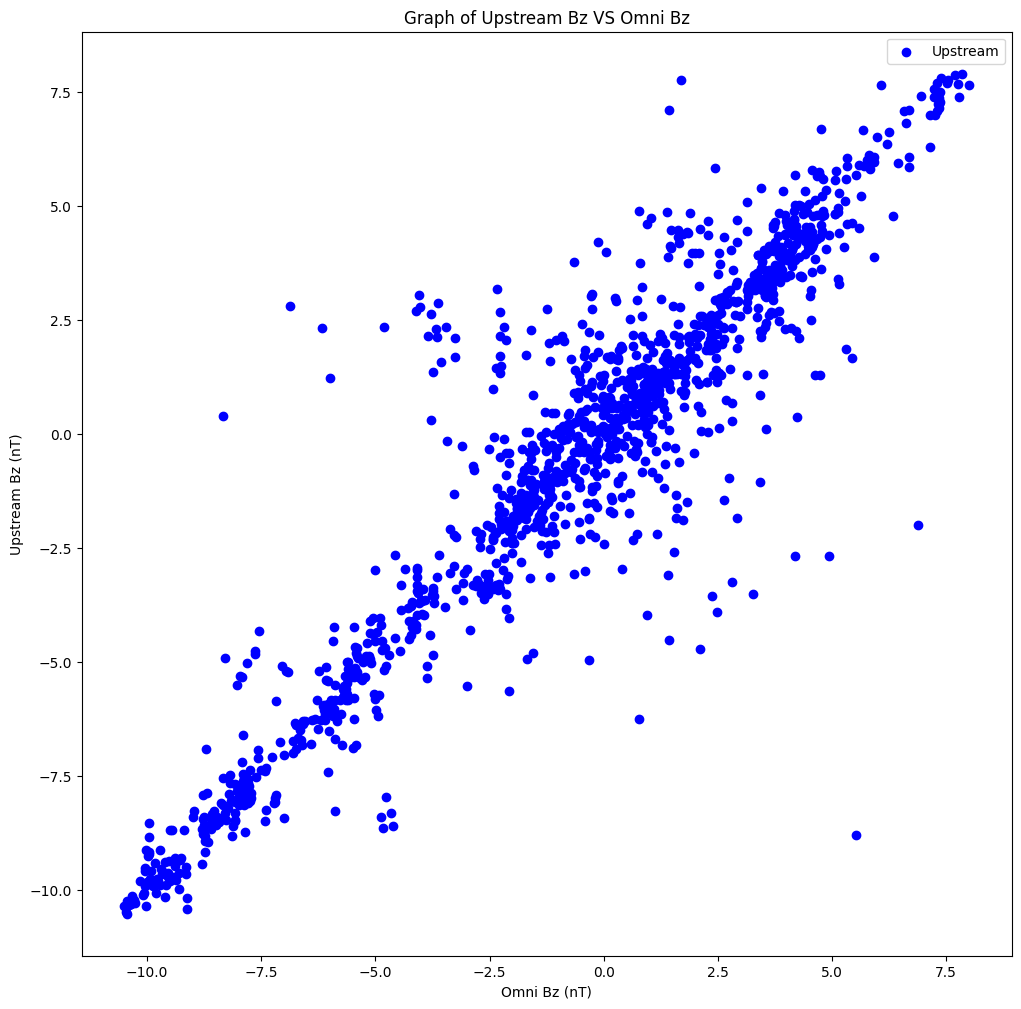

In [61]:
fig, ax = plt.subplots(figsize = (12,12))
plt.scatter(omni['BZ'], upstream_wind['BZ'], label='Upstream', color='blue')

plt.xlabel('Omni Bz (nT)')
plt.ylabel('Upstream Bz (nT)')
plt.title('Graph of Upstream Bz VS Omni Bz')
plt.legend()
plt.show()

In [62]:
#fig, ax = plt.subplots(figsize = (12,4))
#plt.plot(b[0], b[1][:,2], label='Upstream', color='blue', linestyle='-')
#plt.plot(c[0], c[1][:,2], label='Omni', color='red', linestyle='-')

#plt.xlabel('Date')
#plt.ylabel('GSM Bz (nT)')
#plt.title('GSM Bz of Omni Data')
#plt.legend()
#plt.show()

Uploading Data to the web

In [52]:
upstream_wind.to_csv('upstream_output.csv', index=False)